In [1]:
%load_ext autoreload
%autoreload 2

from propose.datasets.human36m.Human36mDataset import NewestHumanDatasetNoRoot
from propose.poses.human36m import Human36mPose

from torch_geometric.loader import DataLoader

import propose.datasets.rat7m.transforms as tr
import propose.datasets.graph_transforms as trg

from propose.models.flows import CondGraphFlow
from propose.training import prior_trainer, supervised_trainer
from propose.models.nn.embedding import SageEmbedding, FlatMLPEmbedding

import torch

import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns

from tqdm import tqdm
from matplotlib.lines import Line2D

In [2]:
embedding_net = SageEmbedding(2, 128, 10) #FlatMLPEmbedding(15 * 2, 128, 16 * 10)
flow = CondGraphFlow(num_layers=10, context_features=10, hidden_features=100, embedding_net=embedding_net)
if torch.cuda.is_available(): flow.to('cuda:0')

In [3]:
print(f'{sum(p.numel() for p in flow.parameters()):,}')

852,546


In [4]:
flow.load_state_dict(torch.load('model_embedding_hrnet_occl_4.pt'))

<All keys matched successfully>

In [6]:
test_dataset = NewestHumanDatasetNoRoot(
    dirname='../../data/human36m/processed/test',
    occlusion_fractions=[],
    mpii=True,
    test=True,
)

Loading dataset...
full pose 2D full pose 3D
1


Preparing test dataset: 100%|██████████| 8486/8486 [00:04<00:00, 1705.31it/s]


['/S9/Walking 1.60457274/2032.jpg', '/S9/Directions 1.58860488/812.jpg', '/S9/Walking.58860488/764.jpg']
Sampling Poses
Sampled 600 poses
Preparing Plots


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


Saving to ./posterior_poses.png
Displaying plot


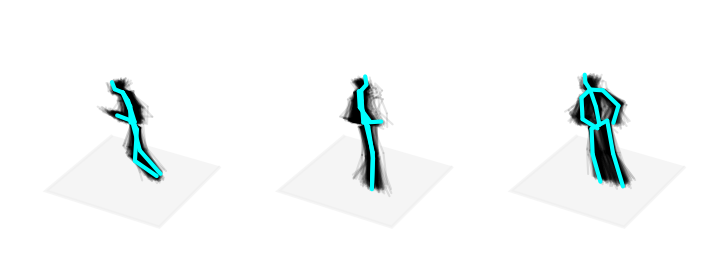

In [6]:
from tqdm import tqdm
from matplotlib.lines import Line2D

sns.set_context('talk')

torch.manual_seed(1)

n_poses = 3
viz_dataloader = DataLoader(test_dataset, batch_size=n_poses, shuffle=True, pin_memory=False, num_workers=0)
batch, _, config = next(iter(viz_dataloader))
print(config['image_path'])

original = batch['x'].x.numpy().reshape(-1, 16, 3)
original_2d = batch['c'].x.numpy()

original = np.insert(original, 0, 0, axis=1)
original_2d = np.insert(original_2d, 0, 0, axis=0)

og_pose = Human36mPose(original)
og_pose_2d = Human36mPose(original_2d)

print('Sampling Poses')
n_samples = 200
samples = flow.sample(n_samples, batch.cuda())
print(f'Sampled {n_poses*n_samples:,} poses')

sample_poses = samples['x'].x.detach().cpu().numpy().reshape(-1, 16, n_samples, 3)
sample_poses = np.insert(sample_poses, 0, 0, axis=1)
sample_poses = sample_poses.swapaxes(1, 2)

poses = Human36mPose(sample_poses)

print(f'Preparing Plots')
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(10, 2), dpi=150)
    fig.subplots_adjust(wspace=0, hspace=0)
    for i in tqdm(range(3)):
        ax = plt.subplot(1, 5, i+1, projection='3d')
        ax.view_init(30, 30)
        poses[i].plot(ax, plot_type='None', c='k', alpha=.1, lw=1)
        og_pose[i].plot(ax, plot_type='None', c='cyan', lw=2)
        
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_zlim(-3, 3)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
        ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))        
        ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
        
        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

        legend_elements = [Line2D([0], [0], color='cyan', label='Ground Truth'),
                           Line2D([0], [0], color='k', alpha=1, label='Samples'),
                          ]

#         if not i:
#             ax.legend(handles=legend_elements, frameon=False)
    
print('Saving to ./posterior_poses.png')
# plt.savefig('./posterior_poses.png', bbox_inches='tight', dpi=150)
print('Displaying plot')
plt.show()

In [27]:
import pickle
with open('../../data/human36m/processed/test/cameras.pkl', 'rb') as f:
    cameras = pickle.load(f)
    
cameras

{'S1': {'54138969': <Camera fx=1145.05 fy=1143.78 cx=512.54 cy=515.45 skew=0.00>,
  '55011271': <Camera fx=1149.68 fy=1147.59 cx=508.85 cy=508.06 skew=0.00>,
  '58860488': <Camera fx=1149.14 fy=1148.80 cx=519.82 cy=501.40 skew=0.00>,
  '60457274': <Camera fx=1145.51 fy=1144.77 cx=514.97 cy=501.88 skew=0.00>},
 'S5': {'54138969': <Camera fx=1145.05 fy=1143.78 cx=512.54 cy=515.45 skew=0.00>,
  '55011271': <Camera fx=1149.68 fy=1147.59 cx=508.85 cy=508.06 skew=0.00>,
  '58860488': <Camera fx=1149.14 fy=1148.80 cx=519.82 cy=501.40 skew=0.00>,
  '60457274': <Camera fx=1145.51 fy=1144.77 cx=514.97 cy=501.88 skew=0.00>},
 'S6': {'54138969': <Camera fx=1145.05 fy=1143.78 cx=512.54 cy=515.45 skew=0.00>,
  '55011271': <Camera fx=1149.68 fy=1147.59 cx=508.85 cy=508.06 skew=0.00>,
  '58860488': <Camera fx=1149.14 fy=1148.80 cx=519.82 cy=501.40 skew=0.00>,
  '60457274': <Camera fx=1145.51 fy=1144.77 cx=514.97 cy=501.88 skew=0.00>},
 'S7': {'54138969': <Camera fx=1145.05 fy=1143.78 cx=512.54 cy=515.

In [8]:
config

{'action': ['Walking 1', 'Directions 1', 'Walking'],
 'camera': ['60457274', '58860488', '58860488'],
 'subject': ['S9', 'S9', 'S9'],
 'occlusion': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 'image_path': ['/S9/Walking 1.60457274/2032.jpg',
  '/S9/Directions 1.58860488/812.jpg',
  '/S9/Walking.58860488/764.jpg'],
 'center3d': tensor([[[-440.9088, -327.8315, 3356.7197]],
 
         [[ 315.0417, -753.0187, 5782.7368]],
 
         [[-491.2943, -706.8994, 5791.0249]]])}

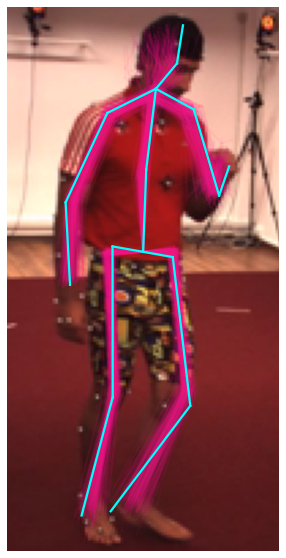

In [9]:
img = plt.imread('./human36m_images/Walking1.60457274.2032.png')

plt.figure(figsize=(10, 10))
plt.imshow(img)

center = config['center3d'][2].numpy()

pose_matrix = og_pose[0].pose_matrix.copy()
pose_matrix[:, 2] = -pose_matrix[:, 2]
pose_matrix[:, [1, 2]] = pose_matrix[:, [2, 1]]
pose = (pose_matrix / 0.0036 + center)
proj_pose = cameras['S9']['58860488'].proj2D(pose)

c = proj_pose[0]
proj_pose = proj_pose - c
proj_pose *= 0.6
proj_pose += c / 3.5
proj_pose[..., 1] += 20

Human36mPose(proj_pose).plot(plt.gca(), plot_type='None', c='cyan', zorder=2)

for i in range(200):
    sample_pose_matrix = poses[0, i].pose_matrix.copy()
    sample_pose_matrix[:, 2] = -sample_pose_matrix[:, 2]
    sample_pose_matrix[:, [1, 2]] = sample_pose_matrix[:, [2, 1]]
    sample_pose = (sample_pose_matrix / 0.0036 + center)
    sample_proj_pose = cameras['S9']['58860488'].proj2D(sample_pose)

    sample_proj_pose = sample_proj_pose - c
    sample_proj_pose *= 0.6
    sample_proj_pose += c / 3.5
    sample_proj_pose[..., 1] += 20

    Human36mPose(sample_proj_pose).plot(plt.gca(), plot_type='None', c='deeppink', alpha=0.05, zorder=1)
    
plt.xlim(proj_pose[0][0] - 50, proj_pose[0][0] + 50)
plt.ylim(proj_pose[0][1] + 110, proj_pose[0][1] - 90)
plt.axis('off')
plt.show()

In [342]:
poses[1].pose_matrix[:, 16].shape

(200, 3)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.patches import FancyArrowPatch, ArrowStyle
class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs)

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

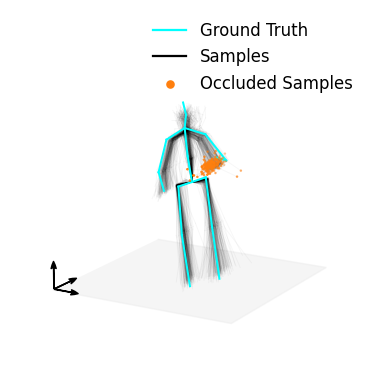

In [43]:
img = plt.imread('./human36m_images/Directions1.58860488.812.png')

fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(15, -60)
poses[1].plot(ax, plot_type='None', c='k', alpha=.03, lw=1)
og_pose[1].plot(ax, plot_type='None', c='cyan', lw=2)

points = poses[1].pose_matrix[:, 16].T
ax.scatter(*points, c='tab:orange', zorder=-10, s=1, label='Occluded Hypotheses')

arrowstyle = ArrowStyle.Fancy(head_width=5, head_length=7)
ax.arrow3D(-3.15, -3.1, -3.1,
           1, 0, 0,
          arrowstyle=arrowstyle,
           mutation_scale=1,
          color='k')
ax.arrow3D(-3.1, -3.15, -3.1,
           0, 1.4, 0,
          arrowstyle=arrowstyle,
          mutation_scale=1,
          color='k')
ax.arrow3D(-3.1, -3.1, -3.15,
           0, 0, 1,
          arrowstyle=arrowstyle,
          mutation_scale=1,
          color='k')

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))        
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

legend_elements = [Line2D([0], [0], color='cyan', label='Ground Truth'),
                           Line2D([0], [0], color='k', alpha=1, label='Samples'),
                   plt.scatter([-100], [-100], color='tab:orange', label='Occluded Samples', s=50)
                          ]

ax.legend(handles=legend_elements, frameon=False)

plt.savefig('./pose_projected_1.png', dpi=150, bbox_inches='tight')
plt.show()

# fig = plt.figure(figsize=(5, 5))
# plt.imshow(img)

# center = config['center3d'][2].numpy()

# pose_matrix = og_pose[1].pose_matrix.copy()
# pose_matrix[:, 2] = -pose_matrix[:, 2]
# pose_matrix[:, [1, 2]] = pose_matrix[:, [2, 1]]
# pose = (pose_matrix / 0.0036 + center)
# proj_pose = cameras['S9']['58860488'].proj2D(pose)

# c = proj_pose[0]
# proj_pose = proj_pose - c
# proj_pose *= 0.33
# proj_pose += c / 3.15
# proj_pose[:, 0] += 52
# proj_pose[:, 1] -= 3

# Human36mPose(proj_pose).plot(plt.gca(), plot_type='None', c='cyan', zorder=2)

# wrists = []
# for i in range(200):
#     sample_pose_matrix = poses[1, i].pose_matrix.copy()
#     sample_pose_matrix[:, 2] = -sample_pose_matrix[:, 2]
#     sample_pose_matrix[:, [1, 2]] = sample_pose_matrix[:, [2, 1]]
#     sample_pose = (sample_pose_matrix / 0.0036 + center)
#     sample_proj_pose = cameras['S9']['58860488'].proj2D(sample_pose)

#     sample_proj_pose = sample_proj_pose - c
#     sample_proj_pose *= 0.33
#     sample_proj_pose += c / 3.15
#     sample_proj_pose[:, 0] += 52
#     sample_proj_pose[:, 1] -= 3

# #     Human36mPose(sample_proj_pose).plot(plt.gca(), plot_type='None', c='k', alpha=0.05, zorder=1)

#     plt.scatter(*sample_proj_pose[16], c='orange', s=10, zorder=1, alpha=1)
#     wrists.append(sample_proj_pose[16])


# # # # wrists = np.stack(wrists)
# # # # hist, x, y = np.histogram2d(wrists[:, 0], wrists[:, 1], bins=[np.linspace(wrists[:, 0].min() - 20, wrists[:, 0].max() + 20, 50), np.linspace(wrists[:, 1].min() - 20, wrists[:, 1].max() + 20, 50)], density=True)

# # # # midblue = '#00def8'
# # # # goeblue = '#153268'

# # # # cm = sns.blend_palette([(1, 1, 1, 0), 'deeppink'], as_cmap=True)
# # # # plt.imshow(hist.T, extent=[x.min(), x.max(), y.min(), y.max()], alpha=10 * hist.T/hist.max(), cmap=cm, zorder=1, interpolation='gaussian')

# plt.xlim(proj_pose[0][0] - 75, proj_pose[0][0] + 75)
# plt.ylim(proj_pose[0][1] + 75, proj_pose[0][1] - 75)
# plt.axis('off')

# # # plt.subplot(1, 3, 2) 
# # # plt.imshow(img)
# # # plt.xlim(proj_pose[0][0] - 75, proj_pose[0][0] + 75)
# # # plt.ylim(proj_pose[0][1] + 75, proj_pose[0][1] - 75)
# # # plt.axis('off')

# # plt.savefig('./pose_projected.pdf', dpi=150, bbox_inches='tight')
# plt.savefig('./pose_projected_2.png', dpi=150, bbox_inches='tight')

(96.72437767093336, 171.72437767093336, 189.8536771506425, 39.8536771506425)

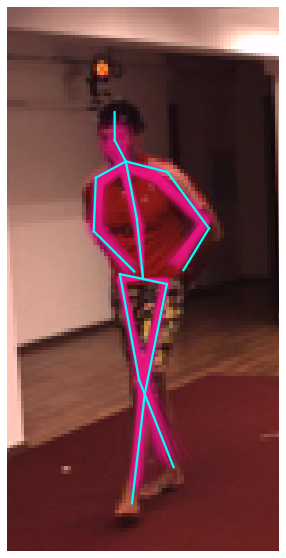

In [299]:
img = plt.imread('./human36m_images/Walking.58860488.764.png')

plt.figure(figsize=(10, 10))
plt.imshow(img)

center = config['center3d'][2].numpy()

pose_matrix = og_pose[2].pose_matrix.copy()
pose_matrix[:, 2] = -pose_matrix[:, 2]
pose_matrix[:, [1, 2]] = pose_matrix[:, [2, 1]]
pose = (pose_matrix / 0.0036 + center)
proj_pose = cameras['S9']['58860488'].proj2D(pose)

c = proj_pose[0]
proj_pose = proj_pose - c
proj_pose *= 0.33
proj_pose += c / 3.15

Human36mPose(proj_pose).plot(plt.gca(), plot_type='None', c='cyan', zorder=2)

for i in range(200):
    sample_pose_matrix = poses[2, i].pose_matrix.copy()
    sample_pose_matrix[:, 2] = -sample_pose_matrix[:, 2]
    sample_pose_matrix[:, [1, 2]] = sample_pose_matrix[:, [2, 1]]
    sample_pose = (sample_pose_matrix / 0.0036 + center)
    sample_proj_pose = cameras['S9']['58860488'].proj2D(sample_pose)

    sample_proj_pose = sample_proj_pose - c
    sample_proj_pose *= 0.33
    sample_proj_pose += c / 3.15

    Human36mPose(sample_proj_pose).plot(plt.gca(), plot_type='None', c='deeppink', alpha=0.05, zorder=1)
    
plt.xlim(proj_pose[0][0] - 37.5, proj_pose[0][0] + 37.5)
plt.ylim(proj_pose[0][1] + 75, proj_pose[0][1] - 75)
plt.axis('off')

  0%|          | 0/4 [00:00<?, ?it/s]

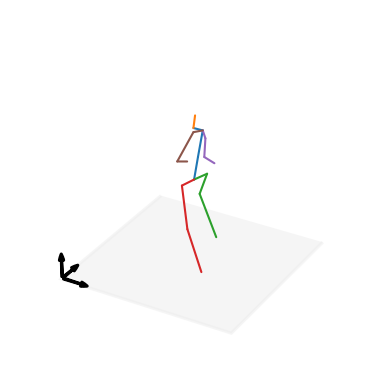

 25%|██▌       | 1/4 [00:00<00:00,  3.58it/s]

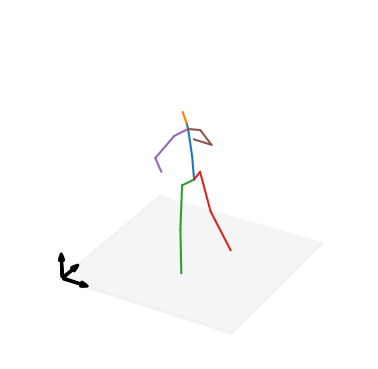

 50%|█████     | 2/4 [00:00<00:00,  3.72it/s]

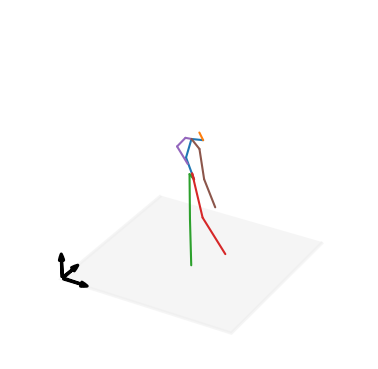

 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

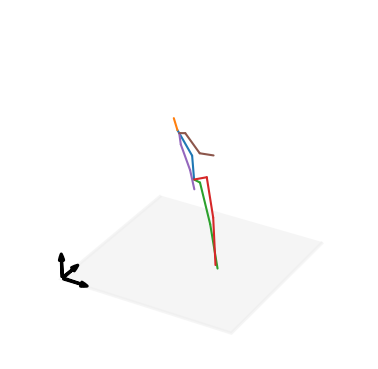

100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


In [71]:
torch.manual_seed(4)

viz_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, pin_memory=False, num_workers=0)
_, batch, config = next(iter(viz_dataloader))

original = batch['x'].x.numpy()

original = np.insert(original, 0, 0, 0)

samples = flow.sample(30, batch.cuda())

sample_poses = samples['x'].x.detach().cpu().numpy()
sample_poses = np.insert(sample_poses, 0, 0, 0)
sample_poses = sample_poses.swapaxes(0, 1)

poses = Human36mPose(sample_poses)

mode = flow.mode_sample(batch.cuda())['x']['x'].detach().cpu().numpy()
mode = np.insert(mode, 0, 0, 0)
mode = mode.swapaxes(0, 1)
mode = Human36mPose(mode)

with sns.axes_style('whitegrid'):
    for i in tqdm(range(4)):
        fig = plt.figure(figsize=(3, 3), dpi=150)
        fig.subplots_adjust(wspace=0, hspace=0)
        ax = plt.subplot(1, 1, 1, projection='3d')
        ax.view_init(30, 30)
        poses[i].plot(ax, lw=1)
        
        arrowstyle = ArrowStyle.Fancy(head_width=2, head_length=3)
        ax.arrow3D(3.2, -3.1, -3.1,
                   -1.2, 0, 0,
                  arrowstyle=arrowstyle,
                   mutation_scale=1,
                  color='k')
        ax.arrow3D(3.1, -3.2, -3.1,
                   0, 1.2, 0,
                  arrowstyle=arrowstyle,
                  mutation_scale=1,
                  color='k')
        ax.arrow3D(3.1, -3.1, -3.2,
                   0, 0, 1.2,
                  arrowstyle=arrowstyle,
                  mutation_scale=1,
                  color='k')

        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_zlim(-3, 3)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
        ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))        
        ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
        
        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

        legend_elements = [Line2D([0], [0], color='cyan', label='Ground Truth'),
                           Line2D([0], [0], color='k', alpha=1, label='Samples'),
                          ]

    # plt.savefig('./prior_poses.png', bbox_inches='tight', dpi=150)
        plt.savefig(f'./prior_poses/{i}.pdf', bbox_inches='tight', dpi=150)
        plt.show()

# Supplementary Figures

100%|██████████| 8/8 [00:00<00:00,  8.84it/s]


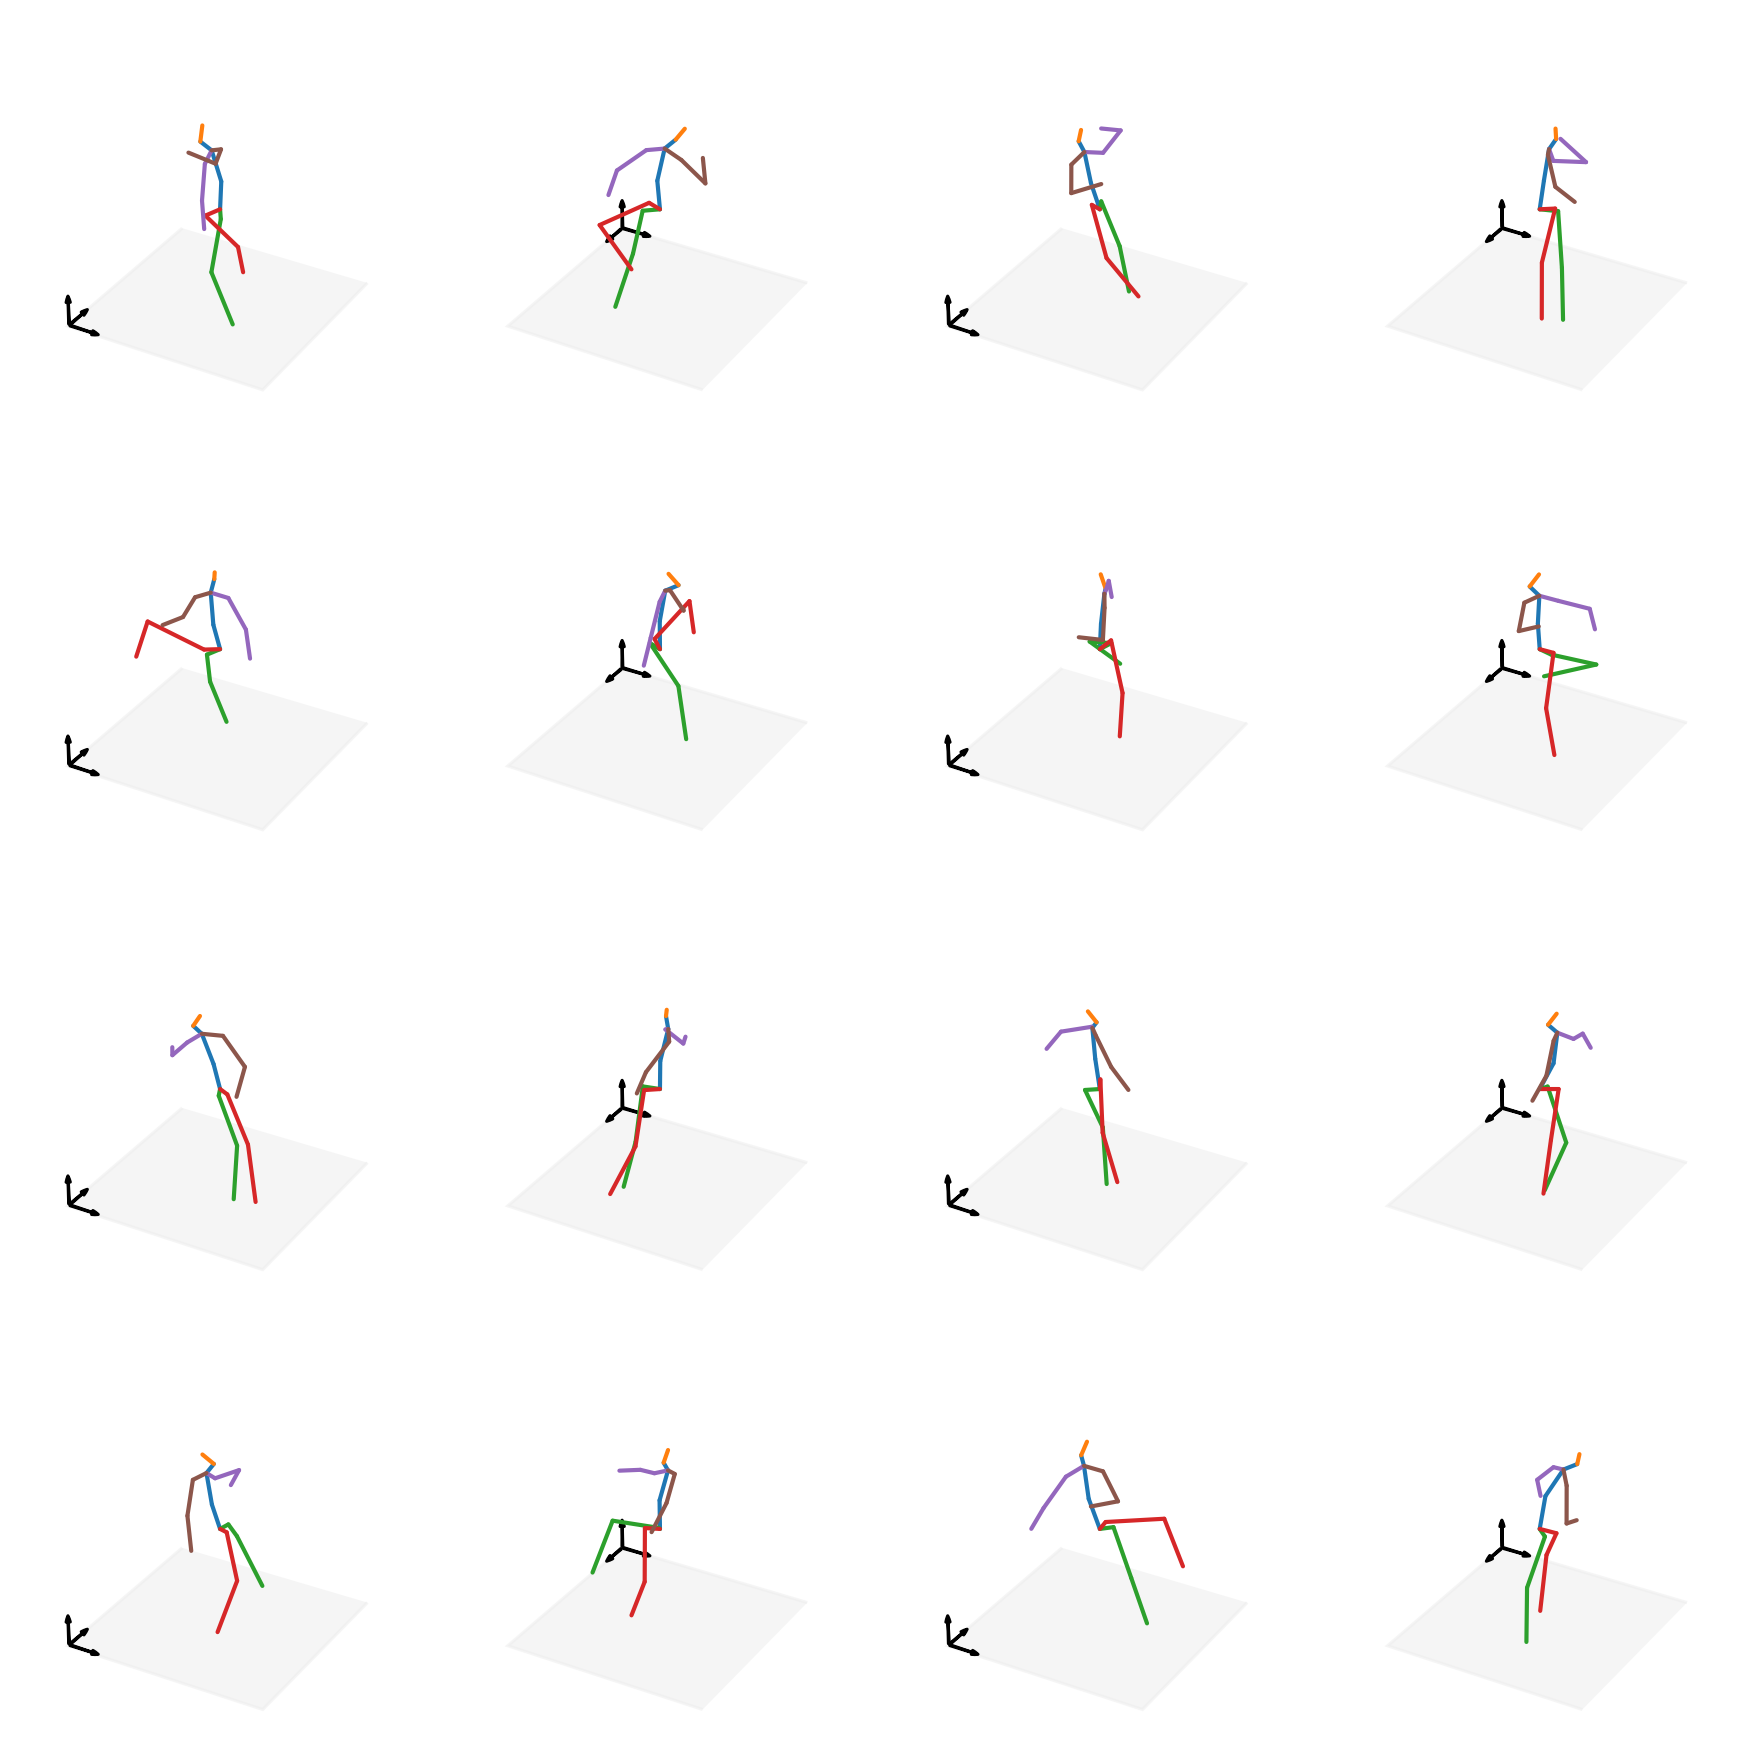

In [41]:
from tqdm import tqdm

torch.manual_seed(4)

viz_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, pin_memory=False, num_workers=0)
_, batch, config = next(iter(viz_dataloader))

original = batch['x'].x.numpy()

original = np.insert(original, 0, 0, 0)

samples = flow.sample(30, batch.cuda())

sample_poses = samples['x'].x.detach().cpu().numpy()
sample_poses = np.insert(sample_poses, 0, 0, 0)
sample_poses = sample_poses.swapaxes(0, 1)

poses = Human36mPose(sample_poses)

mode = flow.mode_sample(batch.cuda())['x']['x'].detach().cpu().numpy()
mode = np.insert(mode, 0, 0, 0)
mode = mode.swapaxes(0, 1)
mode = Human36mPose(mode)

sns.set_context('talk')
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(12, 12), dpi=150)
    fig.subplots_adjust(wspace=0, hspace=0, left=-1)
    for i in tqdm(range(8)):
        for j in range(2):
            ax = plt.subplot(4, 4, i * 2 + j + 1, projection='3d')
            
            ax.dist = 1
            
            if not j:
                ax.view_init(30, 30)
            else:
                ax.view_init(30, 120)

            poses[i + 4].plot(ax, lw=2)

            arrowstyle = ArrowStyle.Fancy(head_width=2, head_length=3)
            ax.arrow3D(3.2, -3.1, -3.1,
                       -1.2, 0, 0,
                      arrowstyle=arrowstyle,
                       mutation_scale=1,
                      color='k')
            ax.arrow3D(3.1, -3.2, -3.1,
                       0, 1.2, 0,
                      arrowstyle=arrowstyle,
                      mutation_scale=1,
                      color='k')
            ax.arrow3D(3.1, -3.1, -3.2,
                       0, 0, 1.2,
                      arrowstyle=arrowstyle,
                      mutation_scale=1,
                      color='k')

            ax.set_xlim(-3, 3)
            ax.set_ylim(-3, 3)
            ax.set_zlim(-3, 3)

            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])

            ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
            ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))        
            ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

            ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

            legend_elements = [Line2D([0], [0], color='cyan', label='Ground Truth'),
                               Line2D([0], [0], color='k', alpha=1, label='Samples'),
                              ]

    # plt.savefig('./prior_poses.png', bbox_inches='tight', dpi=150)
plt.tight_layout()
plt.savefig(f'./prior_poses/combined.pdf', bbox_inches='tight', dpi=150)
plt.show()

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Sampling Poses
Sampled 120 poses


100%|██████████| 4/4 [00:06<00:00,  1.62s/it]


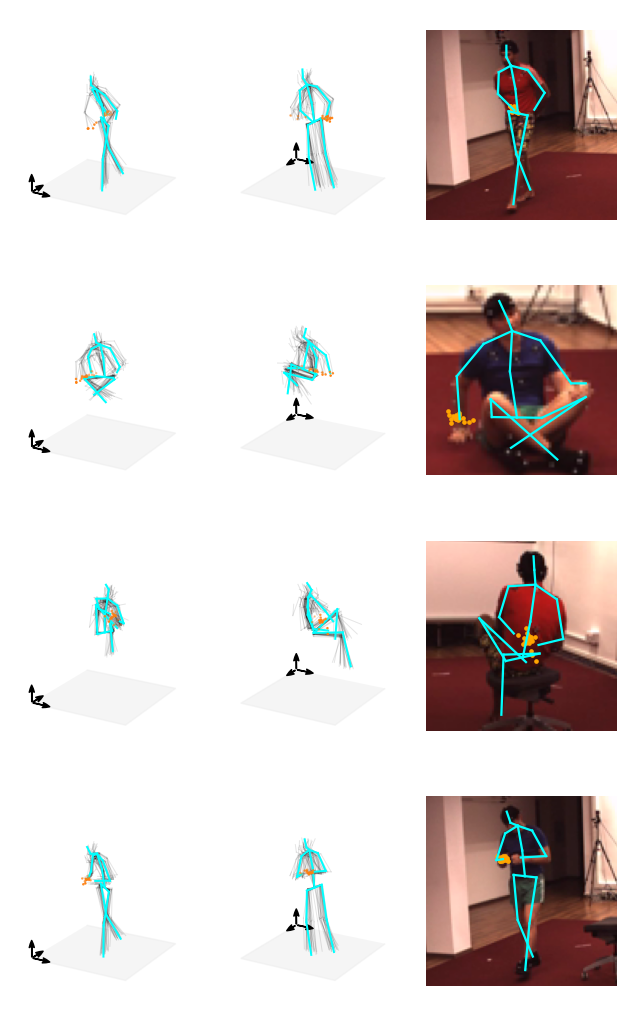

In [40]:
imgs = ['./human36m_images/Walking1.60457274.2032.png', './human36m_images/Directions1.58860488.812.png', './human36m_images/Walking.58860488.764.png', './human36m_images/SittingDown1.60457274.1272.png', './human36m_images/Smoking1.54138969.3540.png', './human36m_images/Phoning1.58860488.284.png']

torch.manual_seed(1)

n_poses = 6
viz_dataloader = DataLoader(test_dataset, batch_size=n_poses, shuffle=True, pin_memory=False, num_workers=0)
batch, _, config = next(iter(viz_dataloader))
print(config['occlusion'])

original = batch['x'].x.numpy().reshape(-1, 16, 3)
original_2d = batch['c'].x.numpy()

original = np.insert(original, 0, 0, axis=1)
original_2d = np.insert(original_2d, 0, 0, axis=0)

og_pose = Human36mPose(original)
og_pose_2d = Human36mPose(original_2d)

print('Sampling Poses')
n_samples = 20
samples = flow.sample(n_samples, batch.cuda())
print(f'Sampled {n_poses*n_samples:,} poses')

sample_poses = samples['x'].x.detach().cpu().numpy().reshape(-1, 16, n_samples, 3)
sample_poses = np.insert(sample_poses, 0, 0, axis=1)
sample_poses = sample_poses.swapaxes(1, 2)

poses = Human36mPose(sample_poses)

# fig = plt.figure(figsize=(7.5 * 1.5, 4.5 * 5))
fig = plt.figure(figsize=(7.5 * 1.5 * 0.8, 4.5 * 5 * 0.8))
for i in tqdm(range(2, n_poses)):
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    
    ax = plt.subplot(5, 3, 1 + (i-2) * 3, projection='3d')
    
    ax.view_init(15, -60)
    poses[i].plot(ax, plot_type='None', c='k', alpha=.1, lw=1)
    og_pose[i].plot(ax, plot_type='None', c='cyan', lw=2)

    points = poses[i].pose_matrix[:, 16].T
    ax.scatter(*points, c='tab:orange', zorder=-10, s=1, label='Occluded Hypotheses')

    arrowstyle = ArrowStyle.Fancy(head_width=5, head_length=7)
    ax.arrow3D(-3.15, -3.1, -3.1,
               1.41, 0, 0,
              arrowstyle=arrowstyle,
               mutation_scale=1,
              color='k')
    ax.arrow3D(-3.1, -3.15, -3.1,
               0, 1.41, 0,
              arrowstyle=arrowstyle,
              mutation_scale=1,
              color='k')
    ax.arrow3D(-3.1, -3.1, -3.15,
               0, 0, 1,
              arrowstyle=arrowstyle,
              mutation_scale=1,
              color='k')

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_zlim(-3, 3)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))        
    ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    if not i:
        legend_elements = [Line2D([0], [0], color='cyan', label='Ground Truth'),
                                   Line2D([0], [0], color='k', alpha=1, label='Samples'),
                           plt.scatter([-100], [-100], color='tab:orange', label='Wrist Hypotheses', s=50)
                                  ]

        ax.legend(handles=legend_elements, frameon=False)
        
    ax = plt.subplot(5, 3, 2 + (i-2) * 3, projection='3d')
    
    ax.view_init(15, 30)
    poses[i].plot(ax, plot_type='None', c='k', alpha=.1, lw=1)
    og_pose[i].plot(ax, plot_type='None', c='cyan', lw=2)

    points = poses[i].pose_matrix[:, 16].T
    ax.scatter(*points, c='tab:orange', zorder=-10, s=1, label='Occluded Hypotheses')

    arrowstyle = ArrowStyle.Fancy(head_width=5, head_length=7)
    ax.arrow3D(-3.15, -3.1, -3.1,
               1.41, 0, 0,
              arrowstyle=arrowstyle,
               mutation_scale=1,
              color='k')
    ax.arrow3D(-3.1, -3.15, -3.1,
               0, 1.41, 0,
              arrowstyle=arrowstyle,
              mutation_scale=1,
              color='k')
    ax.arrow3D(-3.1, -3.1, -3.15,
               0, 0, 1,
              arrowstyle=arrowstyle,
              mutation_scale=1,
              color='k')

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_zlim(-3, 3)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))        
    ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ax = plt.subplot(5, 3, 3 + (i-2) * 3)
    
    img = plt.imread(imgs[i])
    plt.imshow(img)

    center = config['center3d'][i].numpy()

    pose_matrix = og_pose[i].pose_matrix.copy()
    pose_matrix[:, 2] = -pose_matrix[:, 2]
    pose_matrix[:, [1, 2]] = pose_matrix[:, [2, 1]]
    pose = (pose_matrix / 0.0036 + center)
    proj_pose = cameras['S9']['58860488'].proj2D(pose)

    c = proj_pose[0]
    proj_pose = proj_pose - c
    proj_pose *= 0.33
    proj_pose += c / 3.15
    if i == 4:
        proj_pose[:, 1] += 4

    Human36mPose(proj_pose).plot(plt.gca(), plot_type='None', c='cyan', zorder=2)

    wrists = []
    for j in range(n_samples):
        sample_pose_matrix = poses[i, j].pose_matrix.copy()
        sample_pose_matrix[:, 2] = -sample_pose_matrix[:, 2]
        sample_pose_matrix[:, [1, 2]] = sample_pose_matrix[:, [2, 1]]
        sample_pose = (sample_pose_matrix / 0.0036 + center)
        sample_proj_pose = cameras[config['subject'][i]][config['camera'][i]].proj2D(sample_pose)

        sample_proj_pose = sample_proj_pose - c
        sample_proj_pose *= 0.33
        sample_proj_pose += c / 3.15
        if i == 4:
            sample_proj_pose[:, 1] += 4
#         sample_proj_pose[:, 0] += 52
#         sample_proj_pose[:, 1] -= 3

        plt.scatter(*sample_proj_pose[16], c='orange', s=10, zorder=1, alpha=1)
        wrists.append(sample_proj_pose[16])

    x_mean = (proj_pose[:, 0].max() + proj_pose[:, 0].min()) / 2
    
    y_mean = (proj_pose[:, 1].max() + proj_pose[:, 1].min()) / 2
    y_space = max(abs(y_mean - proj_pose[:, 1].max()), abs(y_mean - proj_pose[:, 1].min()))
    y_space *= 1.2

    plt.xlim(x_mean - y_space, x_mean + y_space)
    plt.ylim(y_mean + y_space, y_mean - y_space)
    plt.axis('off')

plt.tight_layout()
plt.savefig('./poses_projected_examples.pdf', dpi=150, bbox_inches='tight')
plt.show()
# plt.savefig('./pose_projected_2.png', dpi=150, bbox_inches='tight')